# Regulatory nets for COVID modeling

In [1]:
using Catlab, Catlab.Graphs, Catlab.CategoricalAlgebra
using Catlab.Graphics, Catlab.Programs

## Signed graphs

In [2]:
@present SchSignedGraph <: SchGraph begin
  Sign::AttrType
  sign::Attr(E, Sign)
end

@abstract_acset_type AbstractSignedGraph <: AbstractGraph

@acset_type SignedGraph(SchSignedGraph, index=[:src, :tgt]) <: AbstractSignedGraph

SignedGraph

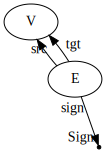

In [3]:
to_graphviz(SchSignedGraph)

In [4]:
g = SignedGraph{Bool}()
add_vertices!(g, 3)
add_edges!(g, [1, 1, 2], [2, 3, 3], sign=[true, true, false])
g

E,src,tgt,sign
1,1,2,true
2,1,3,true
3,2,3,false


In [5]:
function GraphvizGraphs.to_graphviz(g::AbstractSignedGraph; kw...)
  pg = to_graphviz_property_graph(g; kw...)
  for e in edges(g)
    set_eprop!(pg, e, :arrowhead, g[e, :sign] ? "vee" : "tee")
  end
  to_graphviz(pg)
end

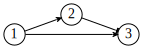

In [6]:
to_graphviz(g, node_labels=true)

### Labeled signed graphs

In [7]:
@present SchLabeledSignedGraph <: SchSignedGraph begin
  Label::AttrType
  label::Attr(V, Label)
end

@acset_type LabeledSignedGraph(SchLabeledSignedGraph,
  index=[:src, :tgt], unique_index=[:label]) <: AbstractSignedGraph

LabeledSignedGraph

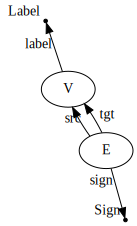

In [8]:
to_graphviz(SchLabeledSignedGraph)

In [9]:
g = LabeledSignedGraph{Bool,Symbol}()
add_vertices!(g, 3, label=[:direct, :indirect, :target])
add_edges!(g, [1, 1, 2], [2, 3, 3], sign=[true, true, false])
g

LabeledSignedGraph{Bool, Symbol} with elements V = 1:3, E = 1:3
┌───┬──────────┐
│ V │    label │
├───┼──────────┤
│ 1 │   direct │
│ 2 │ indirect │
│ 3 │   target │
└───┴──────────┘
┌───┬─────┬─────┬───────┐
│ E │ src │ tgt │  sign │
├───┼─────┼─────┼───────┤
│ 1 │   1 │   2 │  true │
│ 2 │   1 │   3 │  true │
│ 3 │   2 │   3 │ false │
└───┴─────┴─────┴───────┘

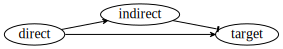

In [10]:
to_graphviz(g, node_labels=:label)

### DSL for signed graphs

Using a Julia macro, create a Graphviz-style domain-specific language (DSL) for signed graphs, where

- normal arrow `→` (`\to`, `\rightarrow`) means activation/promotion
- negated arrow `↛` (`\nrightarrow`) means inhibition

In [11]:
using MLStyle: @match

macro signed_graph(body)
  :(parse_signed_graph(LabeledSignedGraph{Bool,Symbol}, $(Meta.quot(body))))
end

function parse_signed_graph(G::Type, body::Expr)
  g = G()
  for stmt in body.args
    @match stmt begin
      # v
      v::Symbol => add_vertex!(g, label=v)
      # u, v, ...
      Expr(:tuple, vs...) => add_vertices!(g, length(vs), label=vs)
      # u → v
      Expr(:call, :(→), u::Symbol, v::Symbol) =>
        add_edge!(g, only(incident(g, u, :label)), only(incident(g, v, :label)), sign=true)
      # u ↛ v
      Expr(:call, :(↛), u::Symbol, v::Symbol) =>
        add_edge!(g, only(incident(g, u, :label)), only(incident(g, v, :label)), sign=false)
      ::LineNumberNode => nothing
      _ => error("Cannot parse line in graph definition: $stmt")
    end
  end
  return g
end

parse_signed_graph (generic function with 1 method)

Check that it works!

In [12]:
g′ = @signed_graph begin
  direct, indirect, target
  
  direct → indirect
  direct → target
  indirect ↛ target
end

@assert g == g′

## Vaccination models

### Adenovirus-vectored vaccine